**The Two-Mutual-Fund Theorem** :  This theorem states that if you find any two portfolios $\text{P1}$ and $\text{P2}$ who’s risk and return lies on the efficient frontier, then any portfolio of the form $\lambda P1 + (1 − \lambda)P2$ lies on the efficient frontier for $\lambda \in \mathbb{R}$.

In the absence of a risk-free asset, an investor can achieve any desired efficient portfolio even if all that is accessible is a pair of efficient mutual funds. If the location of the desired portfolio on the frontier is between the locations of the two mutual funds, both mutual funds will be held in positive quantities. If the desired portfolio is outside the range spanned by the two mutual funds, then one of the mutual funds must be sold short (held in negative quantity) while the size of the investment in the other mutual fund must be greater than the amount available for investment (the excess being funded by the borrowing from the other fund).

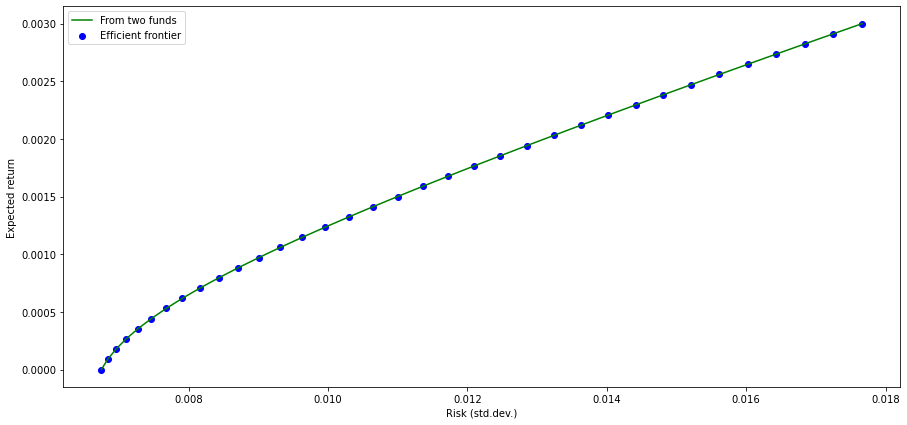

In [28]:
import matplotlib.pyplot as plt
import cvxopt
import numpy as np
import pandas as pd
import yfinance as yf
plt.rcParams['figure.figsize'] = [15,7]

def markowitz_solver( sigma, mu, R ):
    '''
    Solves Markowitz Optimisation problem and returns a dictionary containing optimal weights in
    Markowitz Problem and the minimum Standard Deviation(Risk) that is achieved.

            Parameters:
                    sigma (double) : Return Covariance Matrix.
                    mu (double) :  Mean Returns.
                    R (double) : Target Expected Rate of Returns.

            Returns:
                    ret (double): Dictionary containing two keys weights and Standard deviation (sd).
    '''
    n = len(mu)
    P = 2*sigma
    q = np.zeros(n)  # zero arrays.
    A = np.array([np.ones(n), mu])
    b = np.array([1,R]).T
    res = cvxopt.solvers.qp(
        cvxopt.matrix(P),
        cvxopt.matrix(q), # q
        None, # G
        None, # h
        cvxopt.matrix(A),
        cvxopt.matrix(b))  
     
    # Res is a map with keys, status, x and primal objective.
    status = res['status']
    assert status=="optimal"  # Checking if Optimisation succeeded.
    
    w = res['x']  # Optimal value of x/w in Quadratic/Markowitz problem.
    var = res['primal objective']  # Minimum Variance acheived.
    
    sd = np.sqrt(var)  # Minimum Standard Deviation(risk).
    # Creating Dictionary of weights and standard deviation.
    ret = {}
    ret['weights']=w
    ret['sd']=sd
    
    return ret

def read_return_history():
    """Getting Returns data from Yahoo finance."""

    ticker = ['BCS', 'HSBC', 'BAC', 'C', 'UBS', 'NWG', 'JPM', 'SAN', 'GS', 'MS',
              'LYG', 'BNP', 'WFC', 'USB', 'SCHW', 'BLK', 'DBK', 'MER', 'RY', 'NMR']
    # Create an empty DataFrame to store the Weekly Stock Price Data.
    stock_data = pd.DataFrame()

    # Fetch and append weekly data for each stock to the DataFrame.
    for tkr in ticker:
        stock = yf.download(tkr, start='2014-01-01', end='2023-01-01', interval='1wk', progress=False);
        stock = stock[['Adj Close']]  # Selecting only Adj Close column
        stock.columns = [tkr]  # Rename column to stock symbol
        stock_data = pd.concat([stock_data, stock], axis=1)

    # Reset index to have a clean sequential index
    stock_data.reset_index(inplace=True)
    # Dealing with missing values.
    stock_data = stock_data.ffill()
    stock_data = stock_data.bfill()
    
    # Convert stock_data to a NumPy array
    price_history = stock_data.iloc[:, 1:].to_numpy()

    # Reverse the order of rows in the NumPy array to have the correct chronological order.
    price_history = price_history[::-1]
    
    # Computing Historical weekly returns.
    start_prices = price_history[:-1,:]    # All prices except last row.
    end_prices = price_history[1:,:]     # All prices except first row.
    return_history = (end_prices-start_prices)/start_prices
    return return_history

return_history = read_return_history()
mu = np.mean( return_history, axis = 0)
sigma = np.cov( return_history, rowvar = False )
R1 = 0.001
R2 = 0.002
soln = markowitz_solver(sigma, mu, R1 )
w1 = soln['weights']
soln = markowitz_solver(sigma, mu, R2 )
w2 = soln['weights']
n_points = 35
exp_return = np.zeros(n_points)
sd = np.zeros(n_points)
efficient_sd = np.zeros(n_points)
lambda_vals = np.linspace(-1,2,n_points)
for i in range(0,n_points):
    lbd = lambda_vals[i]
    w = lbd*w1 + (1-lbd)*w2
    sd[i] = np.sqrt(w.transpose() @ sigma @ w)
    exp_return[i] = w.transpose() @ mu
    soln = markowitz_solver(sigma, mu, exp_return[i]  )
    efficient_sd[i] = soln['sd']

ax = plt.gca()
ax.plot( sd, exp_return, label='From two funds', color='g');
ax.scatter( efficient_sd, exp_return, label='Efficient frontier', c = 'b');
ax.legend();
ax.set_xlabel('Risk (std.dev.)')
ax.set_ylabel('Expected return');

The financial significance of the Two-mutual-fund theorem is that a fund manager needs to maintain only two portfolios and they can then provide their customers with an optimal investment portfolio by taking a combination of these two portfolios. In practice this saves a fund manager a lot of work and allows them to reduce transaction costs as they can make similar investments for all their customers.